In [216]:
!pip install folium

    100% |████████████████████████████████| 92kB 518kB/s ta 0:00:01
  Running setup.py bdist_wheel for folium ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/76/b7/93/c439f169af05027d82bac616a1ce124e8d25dbc00d62c146da
Successfully built folium


In [1]:
import psycopg2 as pg2
from psycopg2.extras import RealDictCursor
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

#Function to connect to local postgres database
def connect_to_db():
    con = pg2.connect(host='postgres',
                      dbname='postgres',
                      user='postgres')
    cur = con.cursor(cursor_factory=RealDictCursor)
    return con, cur

#Function to query data from local postgres database
def query_to_dictionary(query, fetch_res=True):
    con, cur = connect_to_db()
    cur.execute(query)
    if fetch_res:
        results = cur.fetchall()
    else:
        results = None
    con.close()
    return results

#Function to insert data into local postgres database table
def insert_query(table, data):
    con, cur = connect_to_db()
    dataText = ','.join([str(row) for row in data])
    cur.execute('INSERT INTO {} VALUES {}'.format(table, dataText))
    cur.execute(query)
    con.close()
    return results

#Function to connect to Pecan Street postgres database
def connect_to_db_ps():
    con = pg2.connect(host='dataport.cloud',
                      dbname='postgres',
                      user='PUDRsO5gAUIG',
                      password='V38W7DWv6Hyh',
                      port=5434)
    cur = con.cursor(cursor_factory=RealDictCursor)
    return con, cur

#Function to query and fetch results from Pecan Street postgres database
def query_db_ps(query, fetch_res=True):
    con, cur = connect_to_db_ps()
    cur.execute(query)
    if fetch_res:
        results = cur.fetchall()
    else:
        results = None
    con.close()
    return results

In [3]:
query_to_dictionary("""
    SELECT count(distinct dataid) from electricity_egauge_hours;
    """, fetch_res=True)

[{'count': 747}]

In [4]:
# Function to import hourly electricity usage from Pecan Street Postgres database into local database

def import_usage():
    dataid_query = query_to_dictionary("""
        SELECT dataid from metadata 
            where dataid not in 
                (select distinct dataid from electricity_egauge_hours) 
        """, fetch_res=True)
    
    dataid_query_ps = query_db_ps("""
        SELECT DISTINCT dataid FROM university.electricity_egauge_hours 
        """, fetch_res=True)

    dataids_ps = [dataid['dataid'] for dataid in dataid_query_ps]
    dataids = [dataid['dataid'] for dataid in dataid_query if dataid['dataid'] in dataids_ps]

    for dataid in dataids:
        usage_data = query_db_ps("""
            SELECT 
                dataid, localhour,
            CASE
                WHEN use IS NULL AND grid IS NULL THEN 0
                WHEN use IS NULL THEN gen+grid
                ELSE use END usage
            FROM university.electricity_egauge_hours WHERE dataid={}
            """.format(dataid), fetch_res=True)
        hourlyusage = [usage['usage'] if usage['usage'] != None else 0 for usage in usage_data]
        localhour = [usage['localhour'] for usage in usage_data]

        print(dataid, len(hourlyusage))        
        tup = [(dataid, str(localhour[i]), str(hourlyusage[i])) for i in range(len(hourlyusage))]

        if len(hourlyusage) > 0:
            args_str = ",".join([str(s) for s in tup])
            query_to_dictionary("""
                BEGIN;
                INSERT INTO electricity_egauge_hours (dataid, localhour, usage)
                    VALUES {};
                COMMIT;""".format(args_str), fetch_res=False)
    

In [7]:
# Used this method to keep trying to connect to Pecan Street because of limited number of allowed connections
import time

for i in range(10000):
    try:
        import_usage()
    except:
        print(i, "unable to connect - ", end="")
        time.sleep(1)
    

0 unable to connect - 1 unable to connect - 2 unable to connect - 3 unable to connect - 4 unable to connect - 5 unable to connect - 6 unable to connect - 7 unable to connect - 8 unable to connect - 9 unable to connect - 10 unable to connect - 11 unable to connect - 12 unable to connect - 13 unable to connect - 14 unable to connect - 15 unable to connect - 16 unable to connect - 17 unable to connect - 18 unable to connect - 19 unable to connect - 20 unable to connect - 21 unable to connect - 22 unable to connect - 23 unable to connect - 24 unable to connect - 25 unable to connect - 26 unable to connect - 27 unable to connect - 28 unable to connect - 29 unable to connect - 30 unable to connect - 31 unable to connect - 32 unable to connect - 33 unable to connect - 34 unable to connect - 35 unable to connect - 36 unable to connect - 37 unable to connect - 38 unable to connect - 39 unable to connect - 40 unable to connect - 41 unable to connect - 42 unable to connect - 43 unable to connect 

3126 16060
8857 22035
6248 21723
5749 21679
9670 2047
573 4974
4674 4950
3676 1623
575 11065
5784 19495
1597 774
9434 15946
1832 3508
7541 2077
5450 18271
9235 18358
8730 3679
3204 13043
8847 16852
1354 14191
2204 5698
621 6611
930 9370
3215 2758
8198 10112
2750 9372
4699 3537
290 unable to connect - 

KeyboardInterrupt: 

In [5]:
query_to_dictionary("""
    SELECT btrim(building_type), count(*) from metadata 
    where dataid in ( SELECT dataid from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/1/2016'
    group by dataid
    having count(*) = (365*24))
    group by building_type
    """, fetch_res=True)

[{'btrim': "'Apartment'", 'count': 13},
 {'btrim': "'Mobile Home'", 'count': 2},
 {'btrim': "'Single-Family Home'", 'count': 336},
 {'btrim': "'Town Home'", 'count': 22}]

In [6]:
query_to_dictionary("""
    select count (*) from (
    SELECT dataid from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/1/2016'
    group by dataid
    having count(*) = (365*24)) a""", fetch_res=True)

[{'count': 373}]

In [7]:
query_to_dictionary("""select * from electricity_egauge_hours 
where localhour >= '1/1/2015' and localhour < '1/1/2016' and
(usage= 0 or usage is null) 
and dataid in (SELECT dataid from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/1/2016'
    group by dataid
    having count(*) = (365*24))""", fetch_res=True)

[{'dataid': 370,
  'localhour': datetime.datetime(2015, 5, 29, 3, 0),
  'usage': 0.0},
 {'dataid': 370,
  'localhour': datetime.datetime(2015, 5, 29, 4, 0),
  'usage': 0.0},
 {'dataid': 370,
  'localhour': datetime.datetime(2015, 5, 29, 5, 0),
  'usage': 0.0},
 {'dataid': 370,
  'localhour': datetime.datetime(2015, 5, 29, 6, 0),
  'usage': 0.0},
 {'dataid': 370,
  'localhour': datetime.datetime(2015, 5, 29, 7, 0),
  'usage': 0.0},
 {'dataid': 370,
  'localhour': datetime.datetime(2015, 5, 29, 8, 0),
  'usage': 0.0},
 {'dataid': 370,
  'localhour': datetime.datetime(2015, 5, 29, 9, 0),
  'usage': 0.0},
 {'dataid': 370,
  'localhour': datetime.datetime(2015, 5, 29, 10, 0),
  'usage': 0.0},
 {'dataid': 370,
  'localhour': datetime.datetime(2015, 5, 29, 11, 0),
  'usage': 0.0},
 {'dataid': 370,
  'localhour': datetime.datetime(2015, 5, 29, 12, 0),
  'usage': 0.0},
 {'dataid': 370,
  'localhour': datetime.datetime(2015, 5, 29, 13, 0),
  'usage': 0.0},
 {'dataid': 370,
  'localhour': datetim

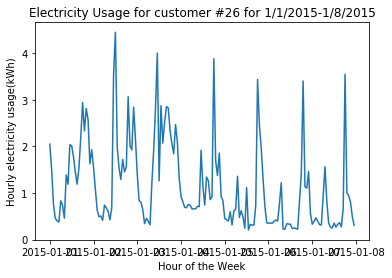

In [8]:
results = query_to_dictionary("""
    SELECT * from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/8/2015'
    and dataid = 26
    """, fetch_res=True)

usage = [x['usage'] for x in results]
hour = [x['localhour'] for x in results]

plt.plot(hour, usage)
plt.xlabel("Hour of the Week")
plt.ylabel("Hourly electricity usage(kWh)")
plt.title("Electricity Usage for customer #26 for 1/1/2015-1/8/2015")


In [9]:
yearly_usage = query_to_dictionary("""
    SELECT dataid, sum(usage) as usage from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/1/2016'
    group by dataid
    having count(*) = (365*24)
    order by dataid
    """, fetch_res=True)

In [10]:
len(yearly_usage)

373

In [11]:
usage_year = [usage['usage'] for usage in yearly_usage]

In [12]:
usage_year

[12540.01505,
 14266.4723,
 14273.6626477685,
 9769.92785000004,
 6101.65694999998,
 11130.3271,
 3998.10861666666,
 5193.51011666666,
 7531.47391666667,
 14571.5021333334,
 3666.02194999999,
 30480.5549166667,
 9968.91888333332,
 21507.6313,
 11941.7045572464,
 15288.6001333333,
 10815.5847833333,
 15032.3649833333,
 5667.43485,
 13878.2872333334,
 14777.8482333333,
 11048.34945,
 7677.81003333333,
 6875.88166666667,
 13277.7265166666,
 10725.8824,
 3959.21673333334,
 9245.55858333332,
 9366.46413333334,
 0.0,
 5147.81590000002,
 8203.51769999998,
 9647.18258333331,
 6730.34873333329,
 18891.9022966779,
 9235.99119999998,
 5788.50944999997,
 7986.16379999996,
 7741.21361666665,
 16179.7781999999,
 15247.8658833333,
 6199.28445000002,
 9228.37306666667,
 4203.81343333334,
 14635.4372000001,
 7096.86711666666,
 7707.46971111108,
 9417.52165000005,
 7323.51525000002,
 4140.69161666667,
 30857.6938333333,
 4793.94185,
 12602.9611,
 9631.46815000003,
 9477.37796666669,
 9809.33316666666,
 

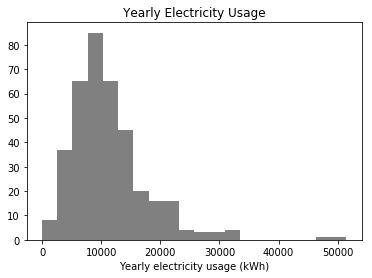

In [13]:
plt.hist(usage_year, bins=20, color="grey")
plt.xlabel('Yearly electricity usage (kWh)')
plt.title('Yearly Electricity Usage')

In [14]:
yearly_usage

[{'dataid': 26, 'usage': 12540.01505},
 {'dataid': 77, 'usage': 14266.4723},
 {'dataid': 86, 'usage': 14273.6626477685},
 {'dataid': 93, 'usage': 9769.92785000004},
 {'dataid': 101, 'usage': 6101.65694999998},
 {'dataid': 114, 'usage': 11130.3271},
 {'dataid': 115, 'usage': 3998.10861666666},
 {'dataid': 160, 'usage': 5193.51011666666},
 {'dataid': 171, 'usage': 7531.47391666667},
 {'dataid': 187, 'usage': 14571.5021333334},
 {'dataid': 203, 'usage': 3666.02194999999},
 {'dataid': 222, 'usage': 30480.5549166667},
 {'dataid': 232, 'usage': 9968.91888333332},
 {'dataid': 252, 'usage': 21507.6313},
 {'dataid': 370, 'usage': 11941.7045572464},
 {'dataid': 434, 'usage': 15288.6001333333},
 {'dataid': 484, 'usage': 10815.5847833333},
 {'dataid': 503, 'usage': 15032.3649833333},
 {'dataid': 516, 'usage': 5667.43485},
 {'dataid': 545, 'usage': 13878.2872333334},
 {'dataid': 547, 'usage': 14777.8482333333},
 {'dataid': 580, 'usage': 11048.34945},
 {'dataid': 585, 'usage': 7677.81003333333},
 {'

In [15]:
house_sq_ft = query_to_dictionary("""
    SELECT dataid, total_square_footage FROM metadata where dataid in (
    SELECT dataid from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/1/2016'
    group by dataid
    having count(*) = (365*24))
    order by dataid
    """, fetch_res=True)

In [16]:
house_sq_ft

[{'dataid': 26, 'total_square_footage': 2075.0},
 {'dataid': 77, 'total_square_footage': 2669.0},
 {'dataid': 86, 'total_square_footage': 1788.0},
 {'dataid': 93, 'total_square_footage': 2934.0},
 {'dataid': 101, 'total_square_footage': 1459.0},
 {'dataid': 114, 'total_square_footage': 1842.0},
 {'dataid': 115, 'total_square_footage': 1001.0},
 {'dataid': 160, 'total_square_footage': 1018.0},
 {'dataid': 171, 'total_square_footage': 2376.0},
 {'dataid': 187, 'total_square_footage': 2122.0},
 {'dataid': 203, 'total_square_footage': 1555.0},
 {'dataid': 222, 'total_square_footage': 2226.0},
 {'dataid': 232, 'total_square_footage': 2228.0},
 {'dataid': 252, 'total_square_footage': 2669.0},
 {'dataid': 370, 'total_square_footage': 2680.0},
 {'dataid': 434, 'total_square_footage': 2158.0},
 {'dataid': 484, 'total_square_footage': 1592.0},
 {'dataid': 503, 'total_square_footage': 2486.0},
 {'dataid': 516, 'total_square_footage': 2379.0},
 {'dataid': 545, 'total_square_footage': 2345.0},
 {'d

In [17]:
sq_ft = [sq_ft['total_square_footage'] for sq_ft in house_sq_ft]

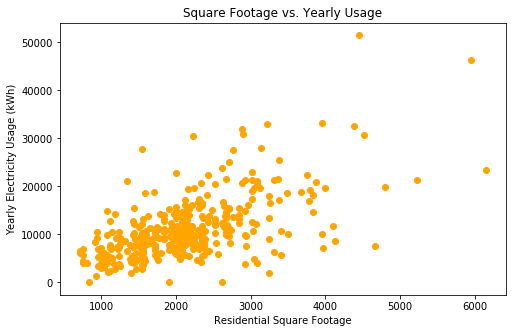

In [18]:
plt.figure(figsize=(8,5))
plt.scatter(sq_ft, usage_year, color="orange")
plt.xlabel("Residential Square Footage")
plt.ylabel("Yearly Electricity Usage (kWh)")
plt.title("Square Footage vs. Yearly Usage")

In [19]:
dataid = [row['dataid'] for row in house_sq_ft]

In [20]:
demo_df = pd.DataFrame(data=dataid, columns=['dataid'])

In [21]:
demo_df['year_usage'] = usage_year

In [22]:
demo_df['sq_ft'] = sq_ft

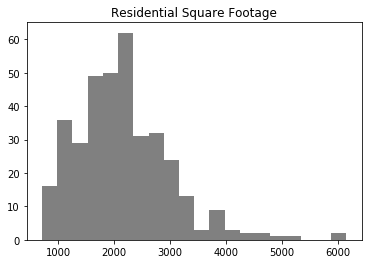

In [23]:
plt.hist(demo_df['sq_ft'][demo_df['sq_ft']>0], bins=20, color="grey")
plt.title("Residential Square Footage")

In [24]:
demo_df['sq_ft'].mean()

2144.4397260273972

In [26]:
people_2014_dict = query_to_dictionary('''
    SELECT 
        dataid, 
        case when residents_13_to_18 is null then '0' else residents_13_to_18 end as age_13_to_18,
        case when residents_19_to_24 is null then '0' else residents_19_to_24 end as age_19_to_24,
        case when residents_25_to_34 is null then '0' else residents_25_to_34 end as age_25_to_34,
        case when residents_35_to_49 is null then '0' else residents_35_to_49 end as age_35_to_49,
        case when residents_50_to_64 is null then '0' else residents_50_to_64 end as age_50_to_64,
        case when residents_65_and_older is null then '0' else residents_65_and_older end as age_older_65,
        case when residents_6_to_12 is null then '0' else residents_6_to_12 end as age_6_to_12,
        case when residents_under_5 is null then '0' else residents_under_5 end as age_under_5
        FROM survey_2014_all_participants where dataid in (
    SELECT dataid from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/1/2016'
    group by dataid
    having count(*) = (365*24))
    order by dataid
    ''', fetch_res=True)

In [27]:
people_2013_dict = query_to_dictionary('''
    SELECT 
        dataid, 
        case when residents_13_to_18 is null then '0' else residents_13_to_18 end as age_13_to_18,
        case when residents_19_to_24 is null then '0' else residents_19_to_24 end as age_19_to_24,
        case when residents_25_to_34 is null then '0' else residents_25_to_34 end as age_25_to_34,
        case when residents_35_to_49 is null then '0' else residents_35_to_49 end as age_35_to_49,
        case when residents_50_to_64 is null then '0' else residents_50_to_64 end as age_50_to_64,
        case when residents_older_65 is null then '0' else residents_older_65 end as age_older_65,
        case when residents_6_to_12 is null then '0' else residents_6_to_12 end as age_6_to_12,
        case when residents_under_5 is null then '0' else residents_under_5 end as age_under_5
        FROM survey_2013_all_participants where dataid in (
    SELECT dataid from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/1/2016'
    group by dataid
    having count(*) = (365*24))
    order by dataid
    ''', fetch_res=True)

In [28]:
people_2012_dict = query_to_dictionary('''
    SELECT 
        dataid, 
        case when num_age_13_to_18 is null then '0' else num_age_13_to_18 end as age_13_to_18,
        case when num_age_19_to_24 is null then '0' else num_age_19_to_24 end as age_19_to_24,
        case when num_age_25_to_34 is null then '0' else num_age_25_to_34 end as age_25_to_34,
        case when num_age_35_to_49 is null then '0' else num_age_35_to_49 end as age_35_to_49,
        case when num_age_50_to_64 is null then '0' else num_age_50_to_64 end as age_50_to_64,
        case when num_age_65_and_older is null then '0' else num_age_65_and_older end as age_older_65,
        case when num_age_6_to_12 is null then '0' else num_age_6_to_12 end as age_6_to_12,
        case when num_age_5_and_under is null then '0' else num_age_5_and_under end as age_under_5
        FROM survey_2012_all_participants where dataid in (
    SELECT dataid from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/1/2016'
    group by dataid
    having count(*) = (365*24))
    order by dataid
    ''', fetch_res=True)

In [29]:
people_2012_dict

[{'age_13_to_18': '0',
  'age_19_to_24': '0',
  'age_25_to_34': "'1'",
  'age_35_to_49': "'1'",
  'age_50_to_64': '0',
  'age_6_to_12': '0',
  'age_older_65': '0',
  'age_under_5': '0',
  'dataid': 114},
 {'age_13_to_18': '0',
  'age_19_to_24': '0',
  'age_25_to_34': '0',
  'age_35_to_49': "'2'",
  'age_50_to_64': '0',
  'age_6_to_12': '0',
  'age_older_65': '0',
  'age_under_5': '0',
  'dataid': 160},
 {'age_13_to_18': '0',
  'age_19_to_24': '0',
  'age_25_to_34': "'5 or more'",
  'age_35_to_49': '0',
  'age_50_to_64': '0',
  'age_6_to_12': '0',
  'age_older_65': '0',
  'age_under_5': '0',
  'dataid': 484},
 {'age_13_to_18': '0',
  'age_19_to_24': '0',
  'age_25_to_34': '0',
  'age_35_to_49': '0',
  'age_50_to_64': '0',
  'age_6_to_12': '0',
  'age_older_65': "'1'",
  'age_under_5': '0',
  'dataid': 585},
 {'age_13_to_18': "'0'",
  'age_19_to_24': "'0'",
  'age_25_to_34': "'0'",
  'age_35_to_49': "'2'",
  'age_50_to_64': "'0'",
  'age_6_to_12': "'0'",
  'age_older_65': "'0'",
  'age_u

In [30]:
people_2011_dict = query_to_dictionary('''
    SELECT 
        dataid, 
        age_13_to_18,                                                                                                                                                                                                                                                                                                         
        age_19_to_24,                                                                                                                                                                                                                                                                                                       
      age_25_to_34,                                                                                                                                                                                                                                                                                                       
      age_35_to_49,                                                                                                                                                                                                                                                                                                        
      age_50_to64 as age_50_to_64,                                                                                                                                                                                                                                                                                                      
      age_6_to_12,                                                                                                                                                                                                                                                                                                      
      age_over_65 as age_older_65,                                                                                                                                                                                                                                                                                                         
      age_under_5
        FROM survey_2011_all_participants where dataid in (
    SELECT dataid from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/1/2016'
    group by dataid
    having count(*) = (365*24))
    order by dataid limit 5
    ''', fetch_res=True)

In [31]:
adults = []
for index, row in demo_df.iterrows():
    num_adults = 'Unknown'
    for data in people_2011_dict:
        if data['dataid'] == row['dataid']:
            num_adults = int(data['age_19_to_24'].strip().strip("'")) + \
                        int(data['age_25_to_34'].strip().strip("'")) + \
                        int(data['age_35_to_49'].strip().strip("'")) + \
                        int(data['age_50_to_64'].strip().strip("'")) 
    for data in people_2012_dict:
        if data['dataid'] == row['dataid']:
            num_adults = int(data['age_19_to_24'].strip("'")) + \
                        int(data['age_25_to_34'][:3].strip().strip("'")) + \
                        int(data['age_35_to_49'].strip().strip("'")) + \
                        int(data['age_50_to_64'].strip().strip("'")) 
    for data in people_2013_dict:
        if data['dataid'] == row['dataid']:
            num_adults = int(data['age_19_to_24'].strip("'")) + \
                        int(data['age_25_to_34'].strip().strip("'")) + \
                        int(data['age_35_to_49'].strip().strip("'")) + \
                        int(data['age_50_to_64'].strip().strip("'")) 
    for data in people_2014_dict:
        if data['dataid'] == row['dataid']:
            num_adults = int(data['age_19_to_24'].strip("'")) + \
                        int(data['age_25_to_34'][:3].strip().strip("'")) + \
                        int(data['age_35_to_49'].strip().strip("'")) + \
                        int(data['age_50_to_64'].strip().strip("'")) 
    adults.append(num_adults)
            
    

In [32]:
demo_df['adults']=adults

In [33]:
children = []
for index, row in demo_df.iterrows():
    num_child = 'Unknown'
    for data in people_2011_dict:
        if data['dataid'] == row['dataid']:
            num_child = int(data['age_under_5'].strip().strip("'")) + \
                        int(data['age_6_to_12'].strip().strip("'")) + \
                        int(data['age_13_to_18'].strip().strip("'")) 
    for data in people_2012_dict:
        if data['dataid'] == row['dataid']:
            num_child = int(data['age_under_5'].strip("'")) + \
                        int(data['age_6_to_12'][:3].strip().strip("'")) + \
                        int(data['age_13_to_18'].strip().strip("'")) 
    for data in people_2013_dict:
        if data['dataid'] == row['dataid']:
            num_child = int(data['age_under_5'].strip("'")) + \
                        int(data['age_6_to_12'].strip().strip("'")) + \
                        int(data['age_13_to_18'].strip().strip("'")) 
    for data in people_2014_dict:
        if data['dataid'] == row['dataid']:
            num_child = int(data['age_under_5'].strip("'")) + \
                        int(data['age_6_to_12'][:3].strip().strip("'")) + \
                        int(data['age_13_to_18'].strip().strip("'")) 
    children.append(num_child)

In [34]:
demo_df['children']=children

In [35]:
seniors = []
for index, row in demo_df.iterrows():
    num_seniors = 'Unknown'
    for data in people_2011_dict:
        if data['dataid'] == row['dataid']:
            num_seniors = int(data['age_older_65'].strip().strip("'")) 
    for data in people_2012_dict:
        if data['dataid'] == row['dataid']:
            num_seniors = int(data['age_older_65'].strip().strip("'")) 
    for data in people_2013_dict:
        if data['dataid'] == row['dataid']:
            num_seniors = int(data['age_older_65'].strip().strip("'")) 
    for data in people_2014_dict:
        if data['dataid'] == row['dataid']:
            num_seniors = int(data['age_older_65'].strip().strip("'")) 
    seniors.append(num_seniors)

In [36]:
demo_df['seniors']=seniors

In [37]:
demo_df_people = demo_df[demo_df['adults']!='Unknown']

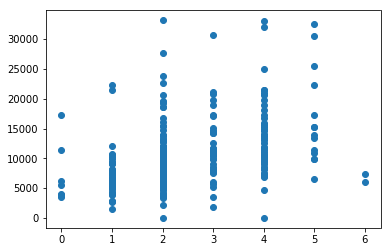

In [38]:
plt.scatter(demo_df_people['adults']+demo_df_people['children']+demo_df_people['seniors'], demo_df_people['year_usage'])

In [39]:
educ_level = query_to_dictionary('''
    SELECT 
        a.dataid, 
        case when b.education_level is not null then b.education_level else 
            case when c.education_level is not null then c.education_level else
                case when d.highest_education_level is not null then d.highest_education_level else
                    case when e.highest_education is not null then BTRIM(e.highest_education) else 'Unknown' end end end end 
                    educ_level  
    from
    (SELECT dataid from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/1/2016' 
    group by dataid
    having count(*) = (365*24)) a
    LEFT JOIN survey_2014_all_participants b ON
        a.dataid = b.dataid
    LEFT JOIN survey_2013_all_participants c ON
        a.dataid = c.dataid
    LEFT JOIN survey_2012_all_participants d ON
        a.dataid = d.dataid
    LEFT JOIN survey_2011_all_participants e ON
        a.dataid = e.dataid
        order by a.dataid
    ''', fetch_res=True)

In [40]:
ed_level = []
for index, row in demo_df.iterrows():
    for data in educ_level:
        if data['dataid'] == row['dataid']:
            ed_level.append(data['educ_level'].strip("'"))
            break
    

In [41]:
demo_df['educ_level'] = ed_level

In [42]:
income = query_to_dictionary('''
    SELECT 
        a.dataid, 
        case when b.total_annual_income is not null then b.total_annual_income else 
            case when c.total_annual_income is not null then c.total_annual_income else
                case when d.annual_income_range is not null then d.annual_income_range else
                    case when e.income_range is not null then BTRIM(e.income_range) else 'Unknown' end end end end 
                    income  
    from
    (SELECT dataid from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/1/2016' 
    group by dataid
    having count(*) = (365*24)) a
    LEFT JOIN survey_2014_all_participants b ON
        a.dataid = b.dataid
    LEFT JOIN survey_2013_all_participants c ON
        a.dataid = c.dataid
    LEFT JOIN survey_2012_all_participants d ON
        a.dataid = d.dataid
    LEFT JOIN survey_2011_all_participants e ON
        a.dataid = e.dataid
        order by a.dataid
    ''', fetch_res=True)

In [43]:
inc = []
for index, row in demo_df.iterrows():
    for data in income:
        if data['dataid'] == row['dataid']:
            inc.append(data['income'].replace(",","").replace("-","").strip("'").strip('"'))
            break
    

In [44]:
demo_df['income'] = inc

In [45]:
building_type = query_to_dictionary("""
    SELECT dataid, building_type FROM metadata where dataid in (
    SELECT dataid from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/1/2016'
    group by dataid
    having count(*) = (365*24))
    order by dataid
    """, fetch_res=True)

In [46]:
demo_df['building_type'] = [row['building_type'].strip(' ').strip("'") for row in building_type]

In [47]:
city = query_to_dictionary("""
    SELECT dataid, btrim(city) city, btrim(state) state from metadata
    where dataid in (SELECT dataid from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/1/2016'
    group by dataid
    having count(*) = (365*24))
    """, fetch_res=True)

In [48]:
demo_df['city'] = [[row['city'].strip("'")+", "+row['state'].strip("'") for row in city if row['dataid']==data['dataid']][0] 
    for index, data in demo_df.iterrows()]

In [ ]:
demo_df['year_usage']

In [50]:
 demo_df.to_csv('../data/demo_df.csv')

In [51]:
hourly_usage = query_to_dictionary("""
    SELECT dataid, localhour, usage from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/1/2016' and 
    dataid in (SELECT dataid from electricity_egauge_hours 
    where localhour >= '1/1/2015' and localhour < '1/1/2016'
    group by dataid
    having count(*) = (365*24))
    order by dataid
    """, fetch_res=True)

In [52]:
dataids = [data['dataid'] for data in hourly_usage]
localhour = [data['localhour'] for data in hourly_usage]
hourlyusage = [data['usage'] for data in hourly_usage]

In [53]:
df = pd.DataFrame({'dataid' : dataids, 'localhour' : localhour, 'usage' : hourlyusage})

In [54]:
df['dayofweek'] = df['localhour'].dt.dayofweek

In [55]:
df['hour'] = df['localhour'].dt.hour

In [57]:
#use linear interpolation to fill in usage gaps of zero where gap <= 4 hours.  Flag accounts with gaps > 4 hours for removal.

from datetime import timedelta
counter = 0
last_non_zero = 0
for id in df['dataid'].unique():
    for index, row in df[df['dataid']==id].sort_values(['localhour']).iterrows():
        if row['usage']==0:
            counter+= 1
            if df[(df['dataid']==id) & (df['localhour']==row['localhour'] + timedelta(hours=1))]['usage'].values[0] != 0:
                df.set_value(index, 'usage', (last_non_zero + df[(df['localhour']==row['localhour']+timedelta(hours=1))&(df['dataid']==id)]['usage'].values[0])/2)
                counter = 0
            else:
                if counter > 4:
                    print(id)
                    break
        else: 
            last_non_zero = row['usage']
            counter = 0 
        

187
370
796
1392
1632
1642
1697
2401
2461
2510
2824
2965
3044
4590
4830
4956
5109
5357
5874
5949
6148
7017
7024
8059
8142
9001
9019
9613
9647
9934


In [58]:
#dataids marked for removal because of gaps > 4 hours
dataid_remove = [187,
370,
796,
1392,
1632,
1642,
1697,
2401,
2461,
2510,
2824,
2965,
3044,
4590,
4830,
4956,
5109,
5357,
5874,
5949,
6148,
7017,
7024,
8059,
8142,
9001,
9019,
9613,
9647,
9934]

In [59]:
clean_df = df[~df['dataid'].isin(dataid_remove)]

In [60]:
clean_df[clean_df['usage']==0]

,dataid,localhour,usage,dayofweek,hour
277426,871,2015-09-02 11:00:00,0.0,2,11
277427,871,2015-09-02 12:00:00,0.0,2,12
406162,1415,2015-05-14 11:00:00,0.0,3,11
406163,1415,2015-05-14 12:00:00,0.0,3,12
406164,1415,2015-05-14 13:00:00,0.0,3,13
406165,1415,2015-05-14 14:00:00,0.0,3,14
467550,1617,2015-05-17 07:00:00,0.0,6,7
1330499,4031,2015-12-22 18:00:00,0.0,1,18
1714352,5275,2015-10-12 06:00:00,0.0,0,6
1896488,5852,2015-03-26 09:00:00,0.0,3,9


In [61]:
#use linear interpolation to fill in remaining usage gaps of zero where gap <= 4 hours.  Flag accounts with gaps > 4 hours for removal.

from datetime import timedelta
counter = 0
last_non_zero = 0
for id in clean_df['dataid'].unique():
    for index, row in clean_df[clean_df['dataid']==id].sort_values(['localhour']).iterrows():
        if row['usage']==0:
            counter+= 1
            if clean_df[(clean_df['dataid']==id) & (clean_df['localhour']==row['localhour'] + timedelta(hours=1))]['usage'].values[0] != 0:
                clean_df.set_value(index, 'usage', (last_non_zero + clean_df[(clean_df['localhour']==row['localhour']+timedelta(hours=1))&(clean_df['dataid']==id)]['usage'].values[0])/2)
                counter = 0
            else:
                if counter > 4:
                    print(id)
                    break
        else: 
            last_non_zero = row['usage']
            counter = 0 

In [64]:
clean_df[clean_df['usage']==0]

,dataid,localhour,usage,dayofweek,hour


In [63]:
clean_df.set_value(277426, 'usage',(clean_df[(clean_df['dataid']==871) & (clean_df['localhour']=='2015-09-02 10:00:00')]['usage'].values[0] + 
 clean_df[(clean_df['dataid']==871) & (clean_df['localhour']=='2015-09-02 12:00:00')]['usage'].values[0])/2)

clean_df.set_value(406162, 'usage',(clean_df[(clean_df['dataid']==1415) & (clean_df['localhour']=='2015-05-14 10:00:00')]['usage'].values[0] + 
 clean_df[(clean_df['dataid']==871) & (clean_df['localhour']=='2015-05-14 14:00:00')]['usage'].values[0])/2)

clean_df.set_value(406163, 'usage',(clean_df[(clean_df['dataid']==1415) & (clean_df['localhour']=='2015-05-14 10:00:00')]['usage'].values[0] + 
 clean_df[(clean_df['dataid']==871) & (clean_df['localhour']=='2015-05-14 14:00:00')]['usage'].values[0])/2)

clean_df.set_value(406164, 'usage',(clean_df[(clean_df['dataid']==1415) & (clean_df['localhour']=='2015-05-14 10:00:00')]['usage'].values[0] + 
 clean_df[(clean_df['dataid']==871) & (clean_df['localhour']=='2015-05-14 14:00:00')]['usage'].values[0])/2)

clean_df.set_value(1896488, 'usage',(clean_df[(clean_df['dataid']==5852) & (clean_df['localhour']=='2015-03-26 08:00:00')]['usage'].values[0] + 
 clean_df[(clean_df['dataid']==871) & (clean_df['localhour']=='2015-03-26 11:00:00')]['usage'].values[0])/2)

clean_df.set_value(1896489, 'usage',(clean_df[(clean_df['dataid']==5852) & (clean_df['localhour']=='2015-03-26 08:00:00')]['usage'].values[0] + 
 clean_df[(clean_df['dataid']==871) & (clean_df['localhour']=='2015-03-26 11:00:00')]['usage'].values[0])/2)

,dataid,localhour,usage,dayofweek,hour
0,26,2015-01-01 00:00:00,2.048917,3,0
1,26,2015-12-31 23:00:00,0.514183,3,23
2,26,2015-12-31 22:00:00,0.450683,3,22
3,26,2015-12-31 21:00:00,0.552550,3,21
4,26,2015-12-31 20:00:00,0.727167,3,20
5,26,2015-12-31 19:00:00,0.657783,3,19
6,26,2015-12-31 18:00:00,0.603067,3,18
7,26,2015-12-31 17:00:00,0.402417,3,17
8,26,2015-12-31 16:00:00,0.303333,3,16
9,26,2015-12-31 15:00:00,0.352550,3,15


In [65]:
clean_df.to_csv('../data/clean_df.csv')

In [67]:
pivot_table_hr_df = clean_df.pivot_table(values='usage', index=['dataid'], columns='localhour')

In [68]:
ttl_usage_df = clean_df.groupby(['dataid'], as_index=False).sum()

In [69]:
ttl_usage_dow_df = clean_df.groupby(['dataid','dayofweek'], as_index=False).sum()

In [70]:
ttl_usage_dow_df

,dataid,dayofweek,usage,hour
0,26,0,1739.587533,14352
1,26,1,1710.081967,14352
2,26,2,1682.540600,14352
3,26,3,1701.408883,14628
4,26,4,1813.361950,14352
5,26,5,1982.338100,14352
6,26,6,1910.696017,14351
7,77,0,2087.350300,14352
8,77,1,1962.690717,14352
9,77,2,1909.671733,14352


In [71]:
ttl_usage_dow_hr_df = clean_df.groupby(['dataid','dayofweek','hour'], as_index=False).sum()

In [72]:
ttl_usage_dow_hr_df['ttl_usage'] = [ttl_usage_df[ttl_usage_df['dataid']==data['dataid']]['usage'].values[0] 
     for index, data in ttl_usage_dow_hr_df.iterrows()]
   

In [74]:
ttl_usage_dow_hr_df['perc_week_usage'] = ttl_usage_dow_hr_df['usage']/ttl_usage_dow_hr_df['ttl_usage']

In [75]:
ttl_usage_dow_hr_df['perc_of_week'] = ttl_usage_dow_hr_df['dayofweek'] + ttl_usage_dow_hr_df['hour']/24.0

In [76]:
ttl_usage_dow_hr_df.to_pickle('../data/ttl_usage_dow_hr_df.pkl')


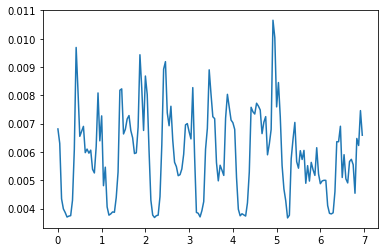

In [77]:
ttl_usage_dow_hr_df_dataid = ttl_usage_dow_hr_df[ttl_usage_dow_hr_df['dataid']==8342]
plt.plot(ttl_usage_dow_hr_df_dataid['perc_of_week'], ttl_usage_dow_hr_df_dataid['perc_week_usage'])

In [79]:
ttl_usage_dow_hr_df['city'] = [[row['city'].strip("'")+", "+row['state'].strip("'") for row in city if row['dataid']==data['dataid']][0] 
    for index, data in ttl_usage_dow_hr_df.iterrows()]

In [80]:
ttl_usage_dow_hr_df['city'].value_counts()/168

Austin, Texas            270.0
Boulder, Colorado         31.0
San Diego, California     13.0
Houston, Texas             9.0
Round Rock, Texas          4.0
Dallas, Texas              3.0
Coppell, Texas             2.0
Arlington, Texas           2.0
McKinney, Texas            2.0
Plano, Texas               2.0
Pflugerville, Texas        1.0
Katy, Texas                1.0
Humble, Texas              1.0
Grapevine, Texas           1.0
Fort Worth, Texas          1.0
Name: city, dtype: float64

In [81]:
from datetime import date, datetime

seasons = {3:(datetime(2015,6,21), datetime(2015,9,22)),
           4:(datetime(2015,9,23), datetime(2015,12,20)),
           2:(datetime(2015,3,21), datetime(2015,6,20))}

def get_season(date):
    for season,(season_start, season_end) in seasons.items():
        if date >=season_start and date <= season_end:
            return season
    else:
        return 1

In [82]:
season = [get_season(row['localhour']) for index, row in clean_df.iterrows()]

In [246]:
df['season'] = season

NameError: name 'season' is not defined

In [255]:
ttl_usage_seas_dow_hr_df = clean_df.groupby(['dataid','season','dayofweek','hour'], as_index=False).sum()

KeyError: 'season'

In [302]:
ttl_usage_seas_dow_hr_df['ttl_usage'] = [ttl_usage_df[ttl_usage_df['dataid']==data['dataid']]['usage'].values[0] 
     for index, data in ttl_usage_seas_dow_hr_df.iterrows()]

In [304]:
ttl_usage_seas_dow_hr_df['perc_week_usage'] = ttl_usage_seas_dow_hr_df['usage']/ttl_usage_seas_dow_hr_df['ttl_usage']

In [305]:
ttl_usage_seas_dow_hr_df['perc_of_week'] = ttl_usage_seas_dow_hr_df['dayofweek'] + ttl_usage_seas_dow_hr_df['hour']/24.0

In [244]:
ttl_usage_seas_dow_hr_df_dataid_1 = ttl_usage_seas_dow_hr_df[(ttl_usage_seas_dow_hr_df['dataid']==4495) 
                                                           & (ttl_usage_seas_dow_hr_df['season']==1)]
ttl_usage_seas_dow_hr_df_dataid_2 = ttl_usage_seas_dow_hr_df[(ttl_usage_seas_dow_hr_df['dataid']==4495) 
                                                           & (ttl_usage_seas_dow_hr_df['season']==2)]
ttl_usage_seas_dow_hr_df_dataid_3 = ttl_usage_seas_dow_hr_df[(ttl_usage_seas_dow_hr_df['dataid']==4495) 
                                                           & (ttl_usage_seas_dow_hr_df['season']==3)]
ttl_usage_seas_dow_hr_df_dataid_4 = ttl_usage_seas_dow_hr_df[(ttl_usage_seas_dow_hr_df['dataid']==4495) 
                                                           & (ttl_usage_seas_dow_hr_df['season']==4)]

plt.figure(figsize=(15,8))
plt.plot(ttl_usage_seas_dow_hr_df_dataid_1['perc_of_week'], 
         ttl_usage_seas_dow_hr_df_dataid_1['perc_week_usage'],label='winter')
plt.plot(ttl_usage_seas_dow_hr_df_dataid_2['perc_of_week'], 
         ttl_usage_seas_dow_hr_df_dataid_2['perc_week_usage'],label='spring')
plt.plot(ttl_usage_seas_dow_hr_df_dataid_3['perc_of_week'], 
         ttl_usage_seas_dow_hr_df_dataid_3['perc_week_usage'],label='summer')
plt.plot(ttl_usage_seas_dow_hr_df_dataid_4['perc_of_week'], 
         ttl_usage_seas_dow_hr_df_dataid_4['perc_week_usage'],label='fall')
plt.legend()
plt.xlabel("Hour of the week - Monday-Sunday")
plt.ylabel("Percent of yearly usage")
plt.title("Percentage of yearly usage used per hour of the week - Customer ID 4495")
plt.show()

NameError: name 'ttl_usage_seas_dow_hr_df' is not defined

In [332]:
ttl_usage_seas_dow_hr_df.to_pickle('../data/ttl_usage_seas_dow_hr_df.pkl')

In [695]:
ttl_usage_seas_dow_hr_df['seas_dow_hr'] = ["S"+str(int(row['season']))+"D"+str(int(row['dayofweek']))+"H"+ ("0" + str(int(row['hour'])))[-2:] for index, row in ttl_usage_seas_dow_hr_df.iterrows()]

In [697]:
pivot_table_df = ttl_usage_seas_dow_hr_df.pivot_table(values='perc_week_usage', index=['dataid'], columns='seas_dow_hr')

In [688]:
#drop accounts with missing usage
pivot_table_df = pivot_table_df[pivot_table_df['S3D6H9'] != 0]

In [214]:
demo_df['city'].unique()

array(['Austin, Texas', 'San Diego, California', 'Boulder, Colorado',
       'Humble, Texas', 'Round Rock, Texas', 'Pflugerville, Texas',
       'Grapevine, Texas', 'Dallas, Texas', 'McKinney, Texas',
       'Houston, Texas', 'Coppell, Texas', 'Plano, Texas',
       'Arlington, Texas', 'Fort Worth, Texas', 'Katy, Texas'], dtype=object)

In [234]:
lat_lon = []
lat_lon.append(['Austin, Texas', 30.27, -97.73])
lat_lon.append(['San Diego, California', 32.7, -117.15])
lat_lon.append(['Boulder, Colorado', 40.02, -105.25])

In [236]:
import folium

# instantiate folium map with starting map point as location
map = folium.Map(location=(35, -106), tiles="OpenStreetMap", zoom_start=5)


#iterate through table rows
for row in lat_lon:
    #set to latitude/longitude coordinates
    coord = [row[1], row[2]]

    #add marker to map
    folium.Marker(
        location=coord,
        popup=(row[0]),
        icon=folium.Icon(color='blue'),
    ).add_to(map)
map